In [1]:
from init import *
from utility import *
from repro import readfile

autotime loaded.


In [2]:
class Reprobus():
    def __init__(self, filename, \
                 nlev=60, nbcon=44, ncm=15, \
                 islev=np.arange(350, 801, 5)):
        p0, rascp = 1000.0, 2.0/7.0
        self.nlev = nlev
        self.filename = filename
        self.date = pd.to_datetime(filename.split('_')[2], format='%Y%m%d%H')
        pj1, uj1, vj1, alt, tj1, qj1, hc = readfile(filename, nlev, nbcon, ncm)  
        aa, bb = self.get_coeffs()
        pmb = np.zeros(tj1.shape)
        for i in np.arange(nlev):
            pmb[:, :, i] = aa[i] + bb[i] * pj1 
        theta = tj1 * ((p0/pmb)**rascp)
            
        tr1 = {'Ozone': 4, 'ClO': 10}
        tr2 = {'HNO3g':42, 'HNO3':3, 'N2O':0} 
        self.long_name = {'Ozone':'O$_3$', 'ClO':'ClO', \
                     'HNO3g':'HNO$_3$ Gas', 'HNO3':'HNO$_3$', \
                     'N2O':'N$_2$O' }
        
        data = xr.Dataset()

        for k, v in tr1.items():           
            data[k] = self.isentropic_tracers(hc[:, :, :, v], theta, islev, k)            
        
        for k, v in tr2.items():
            data[k] = self.isentropic_tracers(qj1[:, :, :, v], theta, islev, k)
        
        self.data = data
        
    def get_coeffs(self, cdir='.'):
        cfile = '%s/ecmwf_%s_levels.txt'%(cdir, self.nlev)
        df = pd.read_csv(cfile, sep='\s+', skiprows=[1])
        aa = 0.01 * df['a'].rolling(1).mean()[1:].values
        bb = df['b'].rolling(1).mean()[1:].values
        return aa, bb
    
    def isentropic_tracers(self, tmp, theta, islev, tr):
        islev = xr.DataArray(islev, dims='Theta', attrs={'units': 'K', 'long_name': 'Temperature'})
        self.lats = xr.DataArray(np.arange(90, -91, -2), dims='Latitude', attrs={'long_name':'Latitude'})
        self.lons = xr.DataArray(np.arange(0, 360, 2), dims='Longitude', attrs={'long_name':'Longitude'})
        self.levs = np.arange(nlev)#[::-1]        
        
        theta = xr.DataArray(theta, \
                             coords=[self.lons, self.lats, self.levs], \
                             dims=['Longitude', 'Latitude', 'Level'], \
                             attrs={'long_name':'Temperature [K]'})
        
        tmp = xr.DataArray(tmp/1e-9, \
                           dims=['Longitude', 'Latitude', 'Level'], \
                           coords=[self.lons, self.lats, self.levs]) 
        
        tmp = xrvinterp(tmp, theta, islev, 'Level', 'Theta')
        tmp.attrs = {'long_name':'%s [ppbv]'%self.long_name[tr]}
        return tmp
        

time: 8.25 ms


In [3]:
nlev = 60
fname = 'MODEL_history_2019050112_001410'
bus = Reprobus(fname, nlev)
bus.data

<xarray.Dataset>
Dimensions:    (Latitude: 91, Longitude: 180, Theta: 91)
Coordinates:
  * Latitude   (Latitude) int64 90 88 86 84 82 80 78 ... -80 -82 -84 -86 -88 -90
  * Longitude  (Longitude) int64 0 2 4 6 8 10 12 ... 346 348 350 352 354 356 358
  * Theta      (Theta) int64 350 355 360 365 370 375 ... 775 780 785 790 795 800
Data variables:
    Ozone      (Longitude, Latitude, Theta) float64 363.2 390.9 ... 2.456e+03
    ClO        (Longitude, Latitude, Theta) float64 0.0003545 ... 8.519e-08
    HNO3g      (Longitude, Latitude, Theta) float64 1.074 1.132 ... 10.26 10.1
    HNO3       (Longitude, Latitude, Theta) float64 1.309 1.38 ... 14.26 14.23
    N2O        (Longitude, Latitude, Theta) float64 313.8 312.7 ... 9.252 8.731

time: 23.8 s


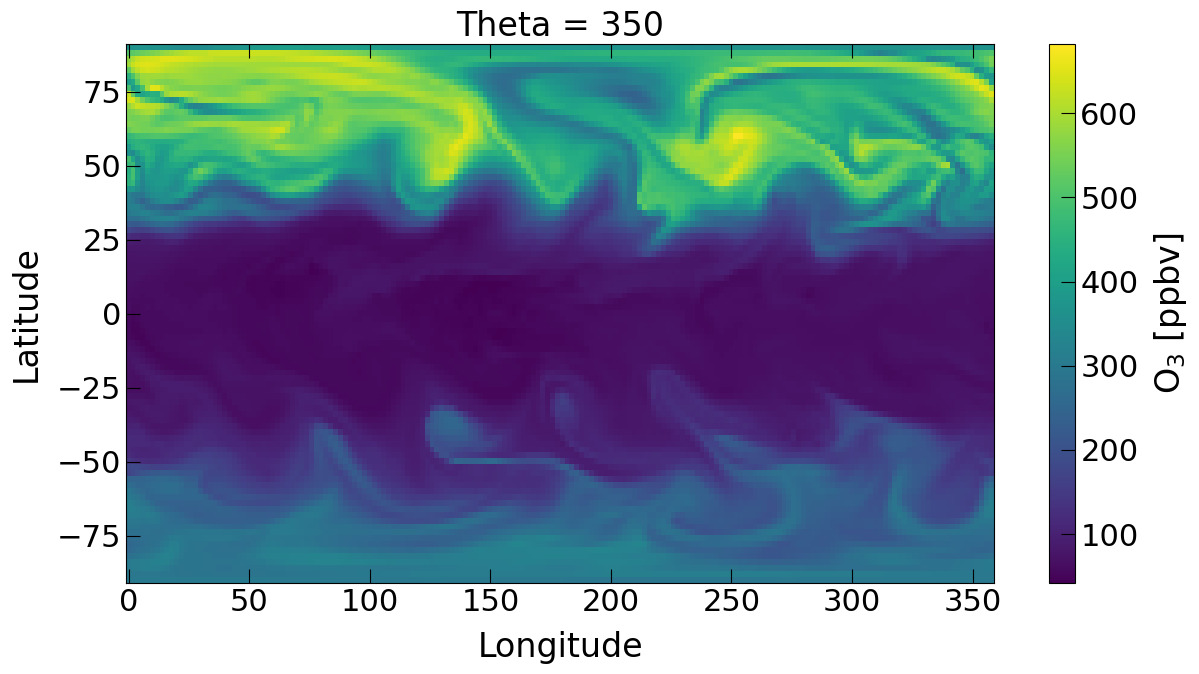

time: 959 ms


In [4]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
bus.data['Ozone'].sel(Theta=350).T.plot(ax=ax)
plt.savefig('altitude_reprobus.png', bbox_inches='tight')
plt.show()